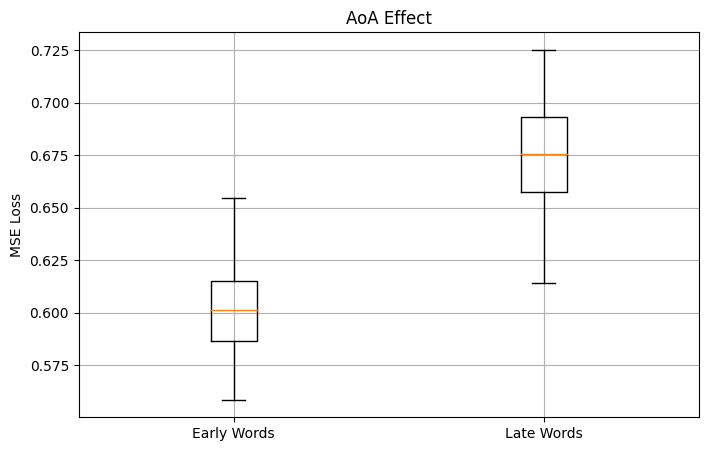

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# 随机种子
torch.manual_seed(0)
np.random.seed(0)

# 参数
N_EARLY = 50
N_LATE = 50
INPUT_DIM = 10
OUTPUT_DIM = 5
HIDDEN_DIM = 20
TOTAL_WORDS = N_EARLY + N_LATE

# 构造伪词的输入和目标语义
X = torch.randn(TOTAL_WORDS, INPUT_DIM)
Y = torch.randn(TOTAL_WORDS, OUTPUT_DIM)

# 分组
X_early, Y_early = X[:N_EARLY], Y[:N_EARLY]
X_late, Y_late = X[N_EARLY:], Y[N_EARLY:]

class SimpleNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    
    def forward(self, x):
        return self.net(x)

def train_network(decay_lr=True):
    model = SimpleNet(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM)
    
    # 初始学习率
    lr_early = 0.1
    lr_late = 0.1

    loss_fn = nn.MSELoss()

    # --- 训练早期词 ---
    optimizer = optim.SGD(model.parameters(), lr=lr_early)
    for epoch in range(100):
        optimizer.zero_grad()
        pred = model(X_early)
        loss = loss_fn(pred, Y_early)
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        early_loss = loss_fn(model(X_early), Y_early).item()
    # --- 训练晚期词 ---
    optimizer = optim.SGD(model.parameters(), lr=lr_late)
    for epoch in range(100):
        optimizer.zero_grad()
        pred = model(X_late)
        loss = loss_fn(pred, Y_late)
        loss.backward()
        optimizer.step()
    
    # --- 最终评估 ---
    with torch.no_grad():
        late_loss = loss_fn(model(X_late), Y_late).item()
    return early_loss, late_loss

import matplotlib.pyplot as plt

n_trials = 30
losses_decay = [train_network(decay_lr=True) for _ in range(n_trials)]

# 拆分
early_loss_decay, late_loss_decay = zip(*losses_decay)

# 可视化
plt.figure(figsize=(8,5))
plt.boxplot([early_loss_decay, late_loss_decay],
            labels=["Early Words", "Late Words"])
plt.ylabel("MSE Loss")
plt.title("AoA Effect")
plt.grid(True)
plt.show()
